In [1]:
import itertools
from climada.engine import Impact
import matplotlib.pyplot as plt

In [2]:
def get_country_data(warming_levels, exposures, country, impact_type='aggr', combinations=[('TC', 'RF')]):
    dir_impacts = {}
    dir_impacts['pop'] = '/Users/szelie/OneDrive - ETH Zurich/data/impacts_multi_risk/'
    dir_impacts['assets'] = '/Users/szelie/OneDrive - ETH Zurich/data/impacts_multi_risk/'

    impact_combined = {warming: {exposure: {combi: 
                   Impact.from_csv(
                       dir_impacts[exposure] + '/countries/{}_{}_impact_{}_150arcsec_{}_{}_v2.csv'.format(
            exposure, impact_type, "_".join(combi), warming, country
        ))
                   for combi in combinations} for exposure in exposures} for warming in warming_levels}
    
    impact_combined_ordered = {warming: {exposure: {combi: 
               Impact.from_csv(
                   dir_impacts[exposure] + '/countries/{}_{}_impact_ordered_{}_150arcsec_{}_{}_v2.csv'.format(
        exposure, impact_type, "_".join(combi), warming, country
    ))
               for combi in combinations} for exposure in exposures} for warming in warming_levels}

    impact_yearsets = {warming: {exposure: {hazard: 
           Impact.from_csv(
               dir_impacts[exposure] + '/countries/{}_{}_impacts_yearsets_150arcsec_{}_{}_v2.csv'.format(
    exposure, hazard, warming, country
    ))
           for hazard in ['TC', 'RF']} for exposure in exposures} for warming in warming_levels}
    return impact_combined, impact_combined_ordered, impact_yearsets



In [3]:
def order_events_by_indices(impact, indices):
    """
    Order event names based on given strings contained in the event names.

    ----------
    impact: Impact
        with event_name based on the given strings
    n_events: Int
        Number of events in the output. Default: 1
    list_string : list
        A list of string based on which to order the events.
        For example climate models ['miroc5','ipsl-cm5a-lr','gfdl-esm2m','hadgem2-es']
        default is None


    Raises
    ------
    AttributeError
        If no list is providing

    Returns
    -------
    impact : Impact
        Impact yearset.

    """
    impact_ordered = Impact()
    if impact_ordered.imp_mat.shape[0]>0:   
        impact_ordered.imp_mat = impact.imp_mat[indices]
    
    impact_ordered.event_name = [impact.event_name[index] for index in indices]
    impact_ordered.event_id = np.arange(len(impact_ordered.event_name))
    frequency = impact.frequency[indices]
    impact_ordered.frequency = frequency*(len(impact.event_id)/len(impact_ordered.event_id))
    impact_ordered.at_event = impact.at_event[indices]
    impact_ordered.aai_agg = np.median(impact_ordered.at_event)
    impact_ordered.coord_exp = impact.coord_exp
    impact_ordered.date = impact.date[indices]
    return impact_ordered

In [4]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import copy


def plot_combined_return(country, warmings, exposures, combinations=[('TC', 'RF')]):
    impact_combined, impact_combined_ordered, impacts_yearsets = get_country_data(warmings,exposures, country, impact_type='aggr')
    fq_ord = {}
    aai_ord = {}
    y100_ord = {}
    fq_single_hazard = {}



    colors = {'1':'crimson'}
    for combi in combinations:
        fq_ord[combi] = {}
        aai_ord[combi] = {}
        y100_ord[combi] = {}
        fq_single_hazard['TC'] = {}
        fq_single_hazard['RF'] = {}
        for exp in exposures:
            fq_ord[combi][exp] = {}
            aai_ord[combi][exp] = {}
            y100_ord[combi][exp] = {}
            fq_single_hazard['TC'][exp] = {}
            fq_single_hazard['RF'][exp] = {}
            for warming in warmings:
                fig, ax = plt.subplots(figsize=(4,3))


                fq_single_hazard['TC'][exp][warming] = []
                fq_single_hazard['RF'][exp][warming] = []
                fq_ord[combi][exp][warming] = []
                aai_ord[combi][exp][warming] = []
                y100_ord[combi][exp][warming] = []
                imp_ord = {}
#                 impact_sum = copy.deepcopy(impact_combined_ordered[warming][exp][combi])
#                 impact_sum.at_event = impacts_yearsets[warming][exp]['TC'].at_event +  impacts_yearsets[warming][exp]['RF'].at_event

                fq_sum = []
                for n in range(1000):
                    imp_ord[warming] = order_events_by_indices(impact_combined_ordered[warming][exp][combi], shuffle(np.arange(5000))[0:500])
#                     imp_ord_sum = order_events_by_indices(impact_sum, shuffle(np.arange(5000))[0:500])

                    fq = imp_ord[warming].calc_freq_curve(np.arange(0,100))
                    fq_ord[combi][exp][warming].append(fq.impact)
                    aai_ord[combi][exp][warming].append(imp_ord[warming].aai_agg)
                    y100_ord[combi][exp][warming].append(fq.impact[99])

#                     fq = imp_ord_sum.calc_freq_curve(np.arange(0,100))
#                     fq_sum.append(fq.impact)

                    for hazard in ['TC','RF']:
                        imp_ord[warming] = order_events_by_indices(impacts_yearsets[warming][exp][hazard], shuffle(np.arange(5000))[0:500])
                        fq = imp_ord[warming].calc_freq_curve(np.arange(0,100))
                        fq_single_hazard[hazard][exp][warming].append(fq.impact)

#                 ax.plot(fq.return_per,np.median(fq_sum,axis=0), color='coral', label= 'sum', linestyle='dashed')
#                 ax.fill_between(fq.return_per,np.median(fq_sum,axis=0),np.percentile(fq_sum,q=95,axis=0), color='coral', alpha=0.3)
#                 ax.fill_between(fq.return_per,np.percentile(fq_sum,q=5,axis=0), np.median(fq_sum,axis=0),color='coral', alpha=0.3)


                ax.plot(fq.return_per,np.median(fq_ord[combi][exp][warming],axis=0), color='crimson', label= 'combined')


                ax.fill_between(fq.return_per,np.median(fq_ord[combi][exp][warming],axis=0),np.percentile(fq_ord[combi][exp][warming],q=95,axis=0), color='crimson', alpha=0.3)
                ax.fill_between(fq.return_per,np.percentile(fq_ord[combi][exp][warming],q=5,axis=0), np.median(fq_ord[combi][exp][warming],axis=0),color='crimson', alpha=0.3)



                for hazard in ['TC','RF']:
                    colors2 = {'TC':'purple', 'RF':'lightblue'}
                    ax.plot(fq.return_per,np.median(fq_single_hazard[hazard][exp][warming],axis=0), color=colors2[hazard], label= hazard)


                    ax.fill_between(fq.return_per,np.median(fq_single_hazard[hazard][exp][warming],axis=0),np.percentile(fq_single_hazard[hazard][exp][warming],q=95,axis=0), color=colors2[hazard], alpha=0.3)
                    ax.fill_between(fq.return_per,np.percentile(fq_single_hazard[hazard][exp][warming],q=5,axis=0), np.median(fq_single_hazard[hazard][exp][warming],axis=0),color=colors2[hazard], alpha=0.3)



                plt.ylabel("".join(["People affected [#]"]))
                if exp == 'assets':
                    plt.ylabel("".join(["Assets damaged [$]"]))


                plt.xlabel("Return period")
                ax.legend()    
                ax.set_title(" ".join(["".join([warming, '.0']), exp, country]))

            #plt.savefig("".join(['/Users/szelie/Dropbox/Applications/Overleaf/multi_risk/figures/aggr_return_period_contribution', exp, '.jpeg']), dpi=1200, bbox_inches='tight')


    

In [13]:
country.alpha_3

'USA'

/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mix

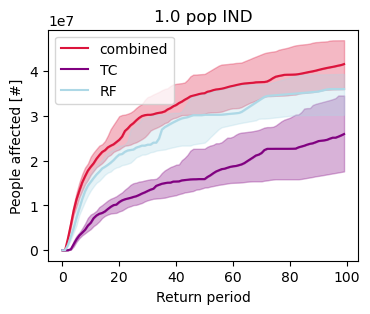

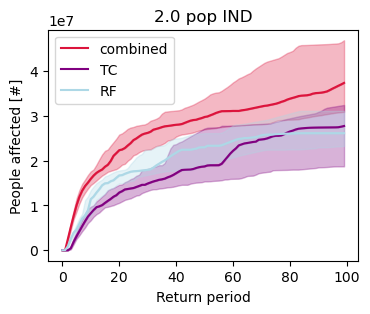

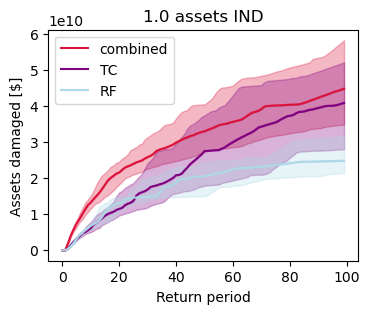

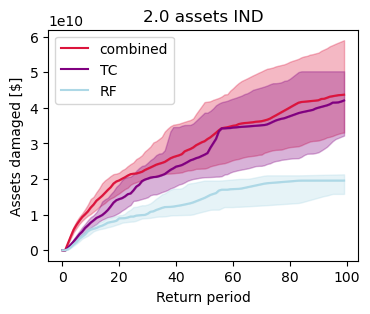

In [15]:
#import pycountry
#country_num_list = [840, 156, 484, 158, 508, 332, 630, 704, 50, 356]
#countries = [pycountry.countries.get(numeric=str(num)) for num in country_num_list]
for country in ['IND']:
     plot_combined_return(country, warmings = ['1','2'], exposures=['pop','assets'])

In [21]:
country

[Country(alpha_2='US', alpha_3='USA', name='United States', numeric='840', official_name='United States of America'),
 Country(alpha_2='CN', alpha_3='CHN', name='China', numeric='156', official_name="People's Republic of China"),
 Country(alpha_2='MX', alpha_3='MEX', name='Mexico', numeric='484', official_name='United Mexican States'),
 Country(alpha_2='TW', alpha_3='TWN', common_name='Taiwan', name='Taiwan, Province of China', numeric='158', official_name='Taiwan, Province of China'),
 Country(alpha_2='MZ', alpha_3='MOZ', name='Mozambique', numeric='508', official_name='Republic of Mozambique'),
 Country(alpha_2='HT', alpha_3='HTI', name='Haiti', numeric='332', official_name='Republic of Haiti'),
 Country(alpha_2='PR', alpha_3='PRI', name='Puerto Rico', numeric='630'),
 Country(alpha_2='VN', alpha_3='VNM', common_name='Vietnam', name='Viet Nam', numeric='704', official_name='Socialist Republic of Viet Nam'),
 None,
 Country(alpha_2='IN', alpha_3='IND', name='India', numeric='356', off

In [44]:
impact_combined_ordered[warming][exposure][combi].eai_exp

array([216.95331894])

In [7]:
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt

def plot_rp_curve(impact_combined_ordered,impact_combined, len_sample=500, len_total=5000, n_sample=1000, max_rp=100, combinations=[('TC', 'RF')], name='aggr'):
    for  warming in impact_combined_ordered:
        for exposure in impact_combined_ordered[warming]:
            for combi in combinations:
                fq_list_ord = []
                fq_list = []

                # Use a list comprehension to generate the values of "imp_ord" and "imp"
                # in a more concise way
                for imp_ord, imp in [(order_events_by_indices(impact_combined_ordered[warming][exposure][combi], shuffle(np.arange(len_total))[0:len_sample]),
                                     order_events_by_indices(impact_combined[warming][exposure][combi], shuffle(np.arange(len_total))[0:len_sample]))
                                    for n in range(n_sample)]:

                    # Store the results of calculating the frequency curves in the appropriate lists
                    fq = imp_ord.calc_freq_curve(np.arange(1,max_rp))
                    fq_list_ord.append(fq.impact)
                    fq = imp.calc_freq_curve(np.arange(1,max_rp))
                    fq_list.append(fq.impact)

                # Create a figure and axes using the "subplots" function from matplotlib
                fig, ax = plt.subplots(figsize=(4,3))

                # Plot the median and 5th and 95th percentile values of the "ordered" and "random" frequency curves
                ax.plot(fq.return_per, np.median(fq_list_ord, axis=0), color='lightblue', label= 'ordered')
                ax.fill_between(fq.return_per, np.median(fq_list_ord, axis=0), np.percentile(fq_list_ord, q=95, axis=0), color='lightblue', alpha=0.3)
                ax.fill_between(fq.return_per, np.percentile(fq_list_ord, q=5, axis=0), np.median(fq_list_ord, axis=0), color='lightblue', alpha=0.3)

                ax.plot(fq.return_per, np.median(fq_list, axis=0), color='coral', label= 'random')
                ax.fill_between(fq.return_per, np.median(fq_list, axis=0), np.percentile(fq_list, q=95, axis=0), color='coral', alpha=0.3)
                ax.fill_between(fq.return_per, np.percentile(fq_list, q=5, axis=0), np.median(fq_list, axis=0), color='coral', alpha=0.3)
                ax.set_title(" ".join([name, warming, exposure]))
                ax.legend()


/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mixed types. Specify dtype option on import or set low_memory=False.
  imp_df = pd.read_csv(file_name)
/Users/szelie/python_projects/climada_python/climada/engine/impact.py:904: DtypeWarning: Columns (0,1,2,3,7,14) have mix

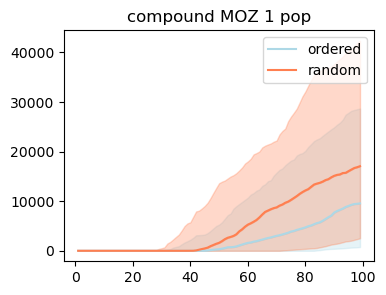

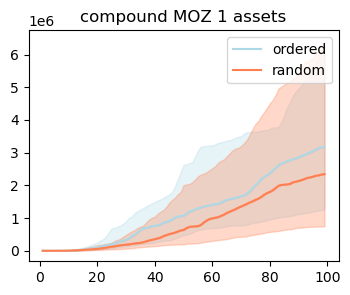

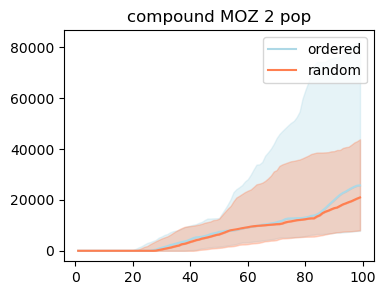

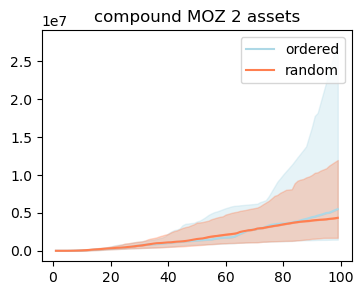

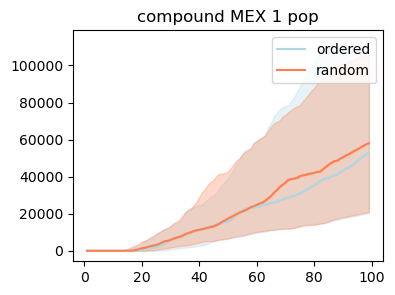

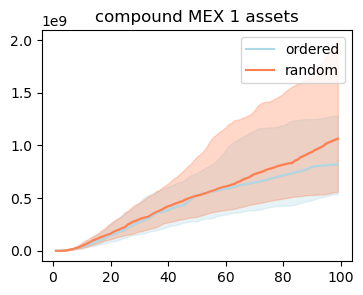

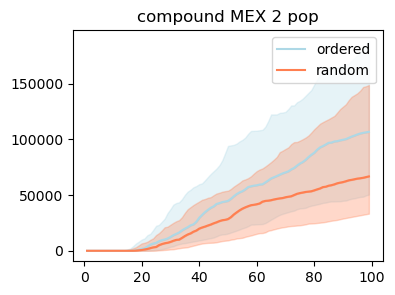

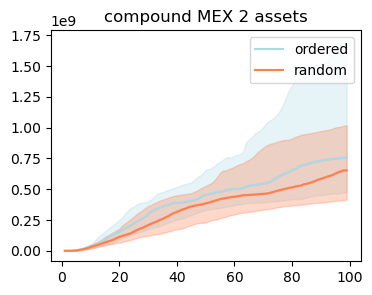

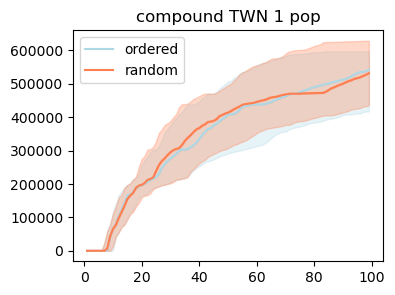

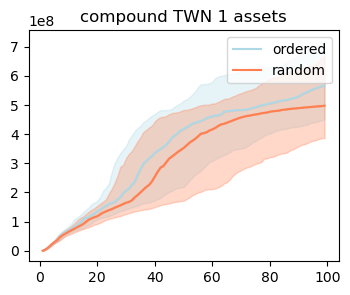

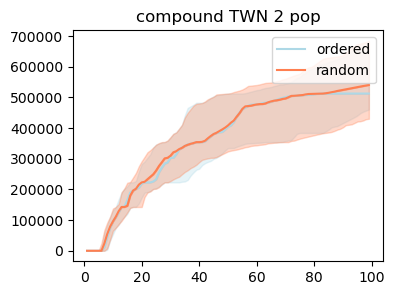

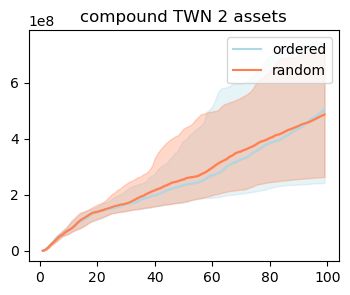

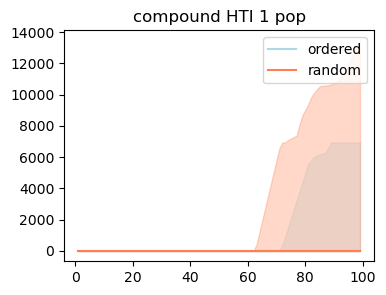

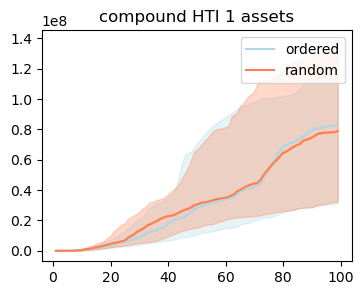

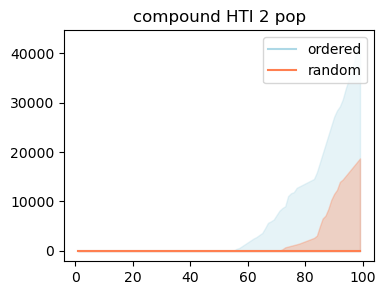

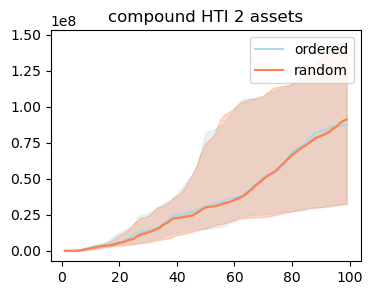

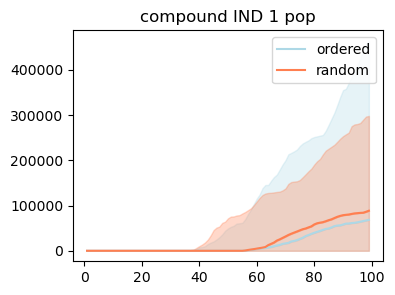

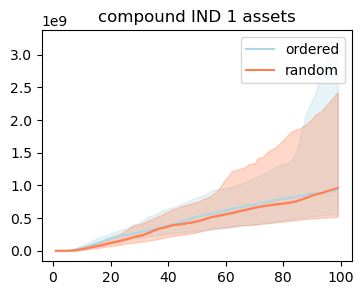

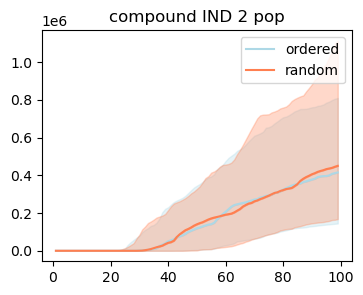

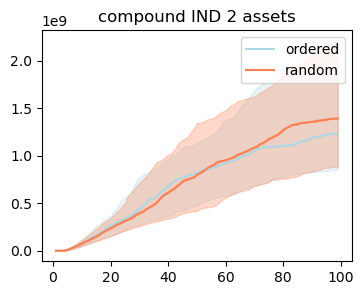

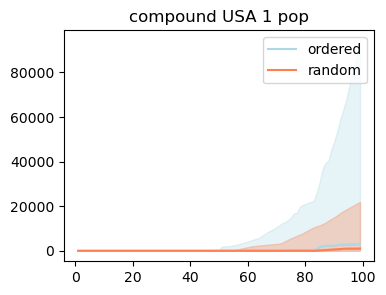

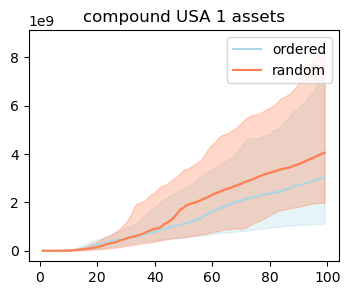

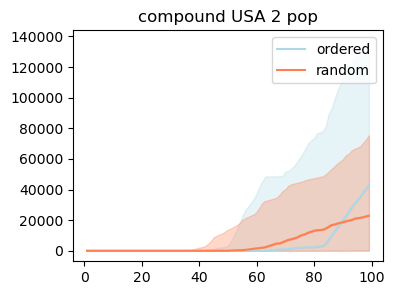

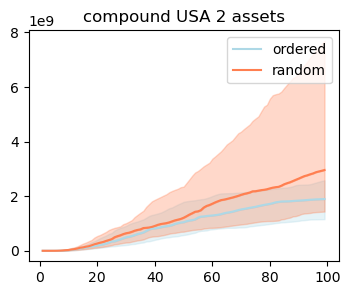

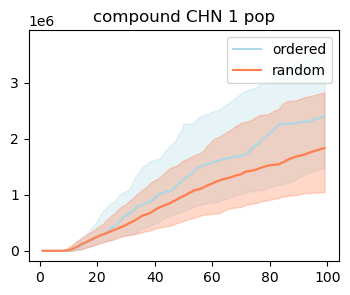

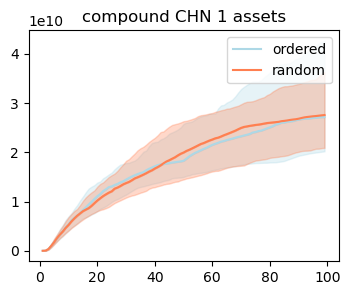

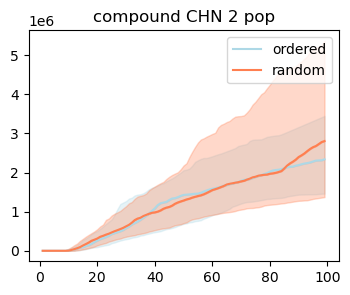

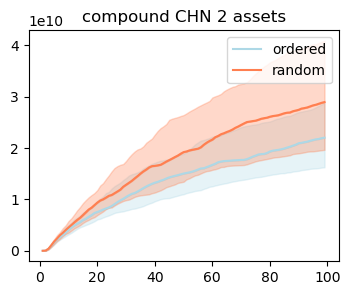

In [8]:
for country in ['MOZ', 'MEX', 'TWN', 'HTI', 'IND', 'USA', 'CHN']:
    impact_combined, impact_combined_ordered, impact_yearsets = get_country_data(['1','2'], ['pop','assets'], country, impact_type='compound')
    plot_rp_curve(impact_combined_ordered,impact_combined,name='compound '+country)